# COMPAS Model Bias Analysis
mk3

## Import Dependencies

In [1]:
# !pip install researchpy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import researchpy as rp

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from dataclasses import dataclass

In [5]:
%matplotlib inline

In [6]:
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250

In [7]:
from sklearn.metrics import confusion_matrix

# Custom functions

#### Dataclass for confusion matrix results

In [8]:
@dataclass
class cmatrix:
    name: str
    TP: int
    FP: int
    TN: int
    FN: int    
    PPV: float
    TPR: float
    FDR: float
    FPR: float
    FOR: float
    FNR: float
    NPV: float
    TNR: float

#### Helper function to generate dataclass _cmatrix_

In [9]:
def gen_dataclass(actual, pred, name):
    [TN, FP, FN, TP] = confusion_matrix(actual, pred).ravel()
    

    PPV = TP / (TP + FP)  # positive predictive value
    FDR = FP / (TP + FP)  # false discovery rate
    
    TPR = TP / (TP + FN)  # true positive rate
    FNR = FN / (TP + FN)  # false negative rate
    
    TNR = TN / (TN + FP)  # true negative rate
    FPR = FP / (TN + FP)  # false positive rate

    FOR = FN / (TN + FN)  # false omission rate
    NPV = TN / (TN + FN)  # negative predictive value

    
    return cmatrix(name, TP, FP, TN, FN, PPV, TPR, FDR, FPR, FOR, FNR, NPV, TNR)

#### Extract bias metrics

In [10]:
def bias_metrics(df):
    '''
    - takes dataframe as input
    - returns dataclass whose components are statistical measures from a confusion matrix
    particular to relu, tanh, elu, and leaky relu dataframe series
    '''
    actual = df.target.values
    relu = df.pred_relu.values
    tanh = df.pred_tanh.values
    elu = df.pred_elu.values
    leaky = df.pred_leaky.values
    
    relu = gen_dataclass(actual, relu, "relu")
    tanh = gen_dataclass(actual, tanh, "tanh")
    elu = gen_dataclass(actual, elu, "elu")
    leaky = gen_dataclass(actual, leaky, "leaky")
    
    return relu, tanh, elu, leaky

# Import Data

In [11]:
data = pd.read_parquet("compas_results_mk2.parquet")

In [12]:
data.head()

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,sex,age_cat_25to45,age_cat_over45,age_cat_under25,race_black,race_asian,race_white,race_hispanic,race_native,race_Other,c_charge_degree,score_text_High,score_text_Low,score_text_Medium,v_score_text_High,v_score_text_Low,v_score_text_Medium,event,target,pred_relu,pred_tanh,pred_elu,pred_leaky
0,25,0,5,0,1,4,-1,1,1,0,5,4,4,32,304,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,1.0,1,1,1,1
1,35,0,4,0,0,3,-1,0,1,0,4,4,3,9,462,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,1.0,1,1,1,1
2,32,0,4,0,0,1,0,0,0,0,4,3,1,0,1171,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0.0,0,0,0,0
3,20,0,10,0,0,0,-1,1,1,1,10,10,0,3,20,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1.0,1,1,1,1
4,50,0,8,0,2,24,0,1,1,1,8,8,24,32,87,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1.0,1,1,1,1


In [13]:
features = list(data.columns[-5:])
features

['target', 'pred_relu', 'pred_tanh', 'pred_elu', 'pred_leaky']

#### Inspect Data

**Note:** The following confusion matrix should return a list of four (4) numbers, with zero (0) false negatives and false positives. Example: array([100, 0, 0, 10])

In [14]:
confusion_matrix(data.target, data.target).ravel()

array([1114,    0,    0,  959])

In [15]:
print("Name\t    Total   TP     FP   TN     FN")
for f in features:
    total = data[f].sum()
    try:
        [tn, fp, fn, tp] = confusion_matrix(data.target, data[f]).ravel()
    except Exception:
        pass
    print(f"{f:10s}: {total:5.0f}  {tp:5.0f} {fp:5.0f} {tn:6.0f} {fn:5.0f}")

Name	    Total   TP     FP   TN     FN
target    :   959    959     0   1114     0
pred_relu :  1061    932   129    985    27
pred_tanh :  1023    953    70   1044     6
pred_elu  :   997    933    64   1050    26
pred_leaky:  1041    921   120    994    38


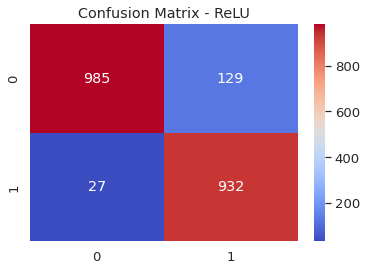

In [16]:
cm_relu = confusion_matrix(data.target, data.pred_relu)
sns.set(font_scale=1.2)
sns.heatmap(cm_relu, annot=True, cmap="coolwarm", robust=True, fmt='g')
plt.title("Confusion Matrix - ReLU")
plt.show()

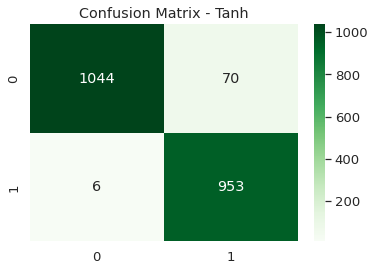

In [17]:
cm_tanh = confusion_matrix(data.target, data.pred_tanh)
sns.set(font_scale=1.2)
sns.heatmap(cm_tanh, annot=True, cmap="Greens", robust=True, fmt='g')
plt.title("Confusion Matrix - Tanh")
plt.show()

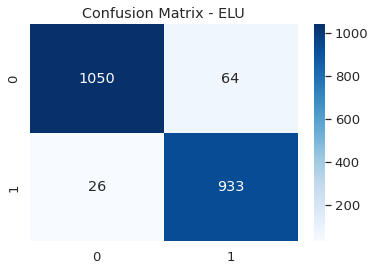

In [18]:
cm_elu = confusion_matrix(data.target, data.pred_elu)
sns.set(font_scale=1.2)
sns.heatmap(cm_elu, annot=True, cmap="Blues", robust=True, fmt='g')
plt.title("Confusion Matrix - ELU")
plt.show()

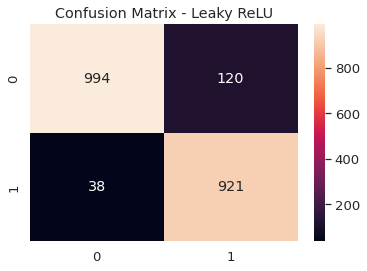

In [19]:
cm_leaky = confusion_matrix(data.target, data.pred_leaky)
sns.set(font_scale=1.2)
sns.heatmap(cm_leaky, annot=True, fmt='g')
plt.title("Confusion Matrix - Leaky ReLU")
plt.show()

## Separate by protected feature

In [20]:
# group A : protected attribute
# group B : other
GroupA = data[data["race_black"] == 1]
GroupB = data[data["race_white"] == 0]
attribute = ["black", "white"]

In [21]:
GroupA.shape

(1075, 38)

In [22]:
GroupB.shape

(1376, 38)

In [23]:
data.shape

(2073, 38)

##### Control stats, baseline

In [24]:
Cr, Ct, Ce, Cl = bias_metrics(data)

In [25]:
Ct.TPR

0.9937434827945777

##### Stats for Group A and Group B dataframes

In [26]:
Ar, At, Ae, Al = bias_metrics(GroupA)
Br, Bt, Be, Bl = bias_metrics(GroupB)

In [27]:
At.TPR

0.9982238010657194

# Bias Testing

#### Predictive parity

Compares precision (or positive predictive value, PPV) between group with protected attribute and without protected attribute. In this instance female group with male group

In [28]:
pp = [
    Ar.PPV == Br.PPV,
    At.PPV == Bt.PPV,
    Ae.PPV == Be.PPV,
    Al.PPV == Bl.PPV
]

In [29]:
pp_diff_r = 1 - (min(Ar.PPV,Br.PPV)/ max(Ar.PPV, Br.PPV))
pp_diff_t = 1 - (min(At.PPV, Bt.PPV)/ max(At.PPV, Bt.PPV))
pp_diff_e = 1 - (min(Ae.PPV, Be.PPV)/ max(Ae.PPV, Be.PPV))
pp_diff_l = 1 - (min(Al.PPV, Bl.PPV)/ max(Al.PPV, Bl.PPV))

In [30]:
print("Predictive parity -")
one = "PPV"
two = "FDR"
print(f"Name\t{one}\t{two}\t{one:11s}{two:10s}\t% Difference")
print(f"{Ar.name}\t{pp[0]}\t{Ar.FDR == Br.FDR}\t{Ar.PPV:0.5f}\t{Br.PPV:10.5f}\t{pp_diff_r:0.5f}")
print(f"{At.name}\t{pp[1]}\t{At.FDR == Bt.FDR}\t{At.PPV:0.5f}\t{Bt.PPV:10.5f}\t{pp_diff_t:0.5f}")
print(f"{Ae.name}\t{pp[2]}\t{Ae.FDR == Be.FDR}\t{Ae.PPV:0.5f}\t{Be.PPV:10.5f}\t{pp_diff_e:0.5f}")
print(f"{Al.name}\t{pp[3]}\t{Al.FDR == Bl.FDR}\t{Al.PPV:0.5f}\t{Bl.PPV:10.5f}\t{pp_diff_l:0.5f}")

Predictive parity -
Name	PPV	FDR	PPV        FDR       	% Difference
relu	False	False	0.86656	   0.87049	0.00452
tanh	False	False	0.92739	   0.92598	0.00153
elu	False	False	0.93423	   0.93172	0.00269
leaky	False	False	0.86888	   0.87466	0.00661


In [31]:
Cr

cmatrix(name='relu', TP=932, FP=129, TN=985, FN=27, PPV=0.8784165881244109, TPR=0.9718456725755996, FDR=0.12158341187558906, FPR=0.11579892280071813, FOR=0.0266798418972332, FNR=0.028154327424400417, NPV=0.9733201581027668, TNR=0.8842010771992819)

#### Predictive Equality

Also called the False Positive Error Balance, this metric considers compares the false positive rates (FPR) between groups.

In [32]:
pe = [
    Ar.FPR == Br.FPR,
    At.FPR == Bt.FPR,
    Ae.FPR == Be.FPR,
    Al.FPR == Bl.FPR    
]

In [33]:
pe_diff_r = 1-(min(Ar.FPR, Br.FPR)/max(Ar.FPR, Br.FPR))
pe_diff_t = 1-(min(At.FPR, Bt.FPR)/max(At.FPR, Bt.FPR))
pe_diff_e = 1-(min(Ae.FPR, Be.FPR)/max(Ae.FPR, Be.FPR))
pe_diff_l = 1-(min(Al.FPR, Bl.FPR)/max(Al.FPR, Bl.FPR))

In [34]:
print("Predictive equality -")
one = "FPR"
two = "TNR"
print(f"Name\t{one}\t{two}\t{one:11s}{two:10s}\t% Difference")
print(f"{Ar.name}\t{pe[0]}\t{Ar.TNR == Br.TNR}\t{Ar.FPR:0.5f}\t{Br.FPR:10.5f}\t{pe_diff_r:0.5f}")
print(f"{At.name}\t{pe[1]}\t{At.TNR == Bt.TNR}\t{At.FPR:0.5f}\t{Bt.FPR:10.5f}\t{pe_diff_t:0.5f}")
print(f"{Ae.name}\t{pe[2]}\t{Ae.TNR == Be.TNR}\t{Ae.FPR:0.5f}\t{Be.FPR:10.5f}\t{pe_diff_e:0.5f}")
print(f"{Al.name}\t{pe[3]}\t{Al.TNR == Bl.TNR}\t{Al.FPR:0.5f}\t{Bl.FPR:10.5f}\t{pe_diff_l:0.5f}")

Predictive equality -
Name	FPR	TNR	FPR        TNR       	% Difference
relu	False	False	0.16602	   0.13701	0.17474
tanh	False	False	0.08594	   0.07486	0.12892
elu	False	False	0.07617	   0.06780	0.10995
leaky	False	False	0.16211	   0.13136	0.18971


#### Equal opportunity

Equal Opportunity entails equal false negative rates (FNR) between groups. Mathematically, true postive rates (TPR) should also be equal.

In [35]:
eo = [
    Ar.FNR == Br.FNR,
    At.FNR == Bt.FNR,
    Ae.FNR == Be.FNR,
    Al.FNR == Bl.FNR
]

In [36]:
eo_diff_r = 1 - (min(Ar.FNR, Br.FNR) / max(Ar.FNR, Br.FNR))
eo_diff_t = 1 - (min(At.FNR, Bt.FNR) / max(At.FNR, Bt.FNR))
eo_diff_e = 1 - (min(Ae.FNR, Be.FNR) / max(Ae.FNR, Be.FNR))
eo_diff_l = 1 - (min(Al.FNR, Bl.FNR) / max(Al.FNR, Bl.FNR))

In [37]:
print("Predictive parity -")
one = "FNR"
two = "TPR"
print(f"Name\t{one}\t{two}\t{one:11s}{two:10s}\t% Difference")
print(f"{Ar.name}\t{eo[0]}\t{Ar.TPR == Br.TPR}\t{Ar.FNR:0.5f}\t{Br.FNR:10.5f}\t{eo_diff_r:0.5f}")
print(f"{At.name}\t{eo[1]}\t{At.TPR == Bt.TPR}\t{At.FNR:0.5f}\t{Bt.FNR:10.5f}\t{eo_diff_t:0.5f}")
print(f"{Ae.name}\t{eo[2]}\t{Ae.TPR == Be.TPR}\t{Ae.FNR:0.5f}\t{Be.FNR:10.5f}\t{eo_diff_e:0.5f}")
print(f"{Al.name}\t{eo[3]}\t{Al.TPR == Bl.TPR}\t{Al.FNR:0.5f}\t{Bl.FNR:10.5f}\t{eo_diff_l:0.5f}")

Predictive parity -
Name	FNR	TPR	FNR        TPR       	% Difference
relu	False	False	0.01954	   0.02395	0.18428
tanh	False	False	0.00178	   0.00749	0.76270
elu	False	False	0.01599	   0.01946	0.17858
leaky	False	False	0.02309	   0.02844	0.18818


#### Statistical Parity

Statistical Parity compares the accuracy of different groups.

In [38]:
Ar_acc = (Ar.TP + Ar.TN) / (Ar.TP + Ar.TN + Ar.FP + Ar.FN)
Br_acc = (Br.TP + Br.TN) / (Br.TP + Br.TN +Br.FP + Br.FN)
r_diff = 1 - (min(Ar_acc, Br_acc) / max(Ar_acc, Br_acc))

In [39]:
At_acc = (At.TP + At.TN) / (At.TP + At.TN + At.FP + At.FN)
Bt_acc = (Bt.TP + Bt.TN) / (Bt.TP + Bt.TN + Bt.FP + Bt.FN)
t_diff = 1 - (min(At_acc, Bt_acc) / max(At_acc, Bt_acc))

In [40]:
Ae_acc = (Ae.TP + Ae.TN) / (Ae.TP + Ae.TN + Ae.FP + Ae.FN)
Be_acc = (Be.TP + Be.TN) / (Be.TP + Be.TN + Be.FP + Be.FN)
e_diff = 1 - (min(Ae_acc, Be_acc) / max(Ae_acc, Be_acc))

In [41]:
Al_acc = (Al.TP + Al.TN) / (Al.TP + Al.TN + Al.FP + Al.FN)
Bl_acc = (Bl.TP + Bl.TN) / (Bl.TP + Bl.TN + Bl.FP + Bl.FN)
l_diff = 1 - (min(Al_acc, Bl_acc) / max(Al_acc, Bl_acc))

In [42]:
sp = [
    Ar_acc == Br_acc,
    At_acc == Bt_acc,
    Ae_acc == Be_acc,
    Al_acc == Bl_acc
]

In [43]:
print("Statistical Parity")
one = f"ACC-{attribute[0][0].capitalize()}"
two = f"ACC-{attribute[1][0].capitalize()}"
print(f"Name\tEqual\t{one:11s}{two}\t% Difference")
print(f"{Ar.name}\t{sp[0]}\t{Ar_acc:0.5f}\t{Br_acc:10.5f}\t{r_diff:0.5f}")
print(f"{At.name}\t{sp[1]}\t{At_acc:0.5f}\t{Bt_acc:10.5f}\t{t_diff:0.5f}")
print(f"{Ae.name}\t{sp[2]}\t{Ae_acc:0.5f}\t{Be_acc:10.5f}\t{e_diff:0.5f}")
print(f"{Al.name}\t{sp[3]}\t{Al_acc:0.5f}\t{Bl_acc:10.5f}\t{l_diff:0.5f}")

Statistical Parity
Name	Equal	ACC-B      ACC-W	% Difference
relu	False	0.91070	   0.91788	0.00782
tanh	False	0.95814	   0.95785	0.00030
elu	False	0.95535	   0.95567	0.00033
leaky	False	0.91070	   0.91860	0.00861


In [44]:
Aset = GroupA.iloc[:,-5:]
Bset = GroupB.iloc[:,-5:]
base = data.iloc[:,-5:]

#### Compare Variances

In [45]:
np.var(Aset)

target        0.249437
pred_relu     0.241433
pred_tanh     0.245940
pred_elu      0.247335
pred_leaky    0.242108
dtype: float64

In [46]:
np.var(Bset)

target        0.249789
pred_relu     0.248035
pred_tanh     0.249586
pred_elu      0.249881
pred_leaky    0.248460
dtype: float64

In [47]:
np.var(base)

target        0.248602
pred_relu     0.249860
pred_tanh     0.249958
pred_elu      0.249637
pred_leaky    0.249995
dtype: float64

In [48]:
np.var(base) == np.var(Aset)

target        False
pred_relu     False
pred_tanh     False
pred_elu      False
pred_leaky    False
dtype: bool

In [49]:
np.var(base) == np.var(Bset)

target        False
pred_relu     False
pred_tanh     False
pred_elu      False
pred_leaky    False
dtype: bool

In [50]:
np.var(Aset) == np.var(Bset)

target        False
pred_relu     False
pred_tanh     False
pred_elu      False
pred_leaky    False
dtype: bool

# Hypothesis Testing

#### Hypothesis test function

In [51]:
def hypothesis_test(p, α=0.05):
    if p > α:
        print("Fail to reject null hypothesis.")
    if p < α:
        print("Reject null hypothesis.")

#### Set α (alpha)

In [52]:
α = 0.01

### Actual results

#### Control and Group A

In [53]:
print(f"Control and {attribute[0].capitalize()}")

try:
    p = rp.ttest(base["target"], Aset["target"], equal_variances=False)[1][3:4].values[0][1]
    hypothesis_test(p, α)

    display(rp.ttest(base["target"], Aset["target"], equal_variances=False)[1][2:4])
    
except ZeroDivisionError:
    print("Cannot calculate due to division by zero in STD.")

Control and Black
Reject null hypothesis.


,Welch's t-test,results
2,t =,-3.2559
3,Two side test p value =,0.0011


#### Control and Group B

In [54]:
print(f"Control and {attribute[1].capitalize()}")

try:
    p = rp.ttest(base["target"], Bset["target"], equal_variances=False)[1][3:4].values[0][1]
    hypothesis_test(p, α)

    display(rp.ttest(base["target"], Bset["target"], equal_variances=False)[1][2:4])
    
except ZeroDivisionError:
    print("Cannot calculate due to division by zero in STD.")

Control and White
Fail to reject null hypothesis.


,Welch's t-test,results
2,t =,-1.3157
3,Two side test p value =,0.1884


#### Group A and Group B

In [55]:
print(f"{attribute[0].capitalize()} and {attribute[1].capitalize()}")

try:
    p = rp.ttest(Aset["target"], Bset["target"], equal_variances=False)[1][3:4].values[0][1]
    hypothesis_test(p, α)

    display(rp.ttest(Aset["target"], Bset["target"], equal_variances=False)[1][2:4])
except ZeroDivisionError:
    print("Cannot calculate due to division by zero in STD.")

Black and White
Fail to reject null hypothesis.


,Welch's t-test,results
2,t =,1.8804
3,Two side test p value =,0.0602


### ReLU Results

#### Control and Group A

In [56]:
print(f"Control and {attribute[0].capitalize()}")

try:
    p = rp.ttest(base["pred_relu"], Aset["pred_relu"], equal_variances=False)[1][3:4].values[0][1]
    hypothesis_test(p, α)

    display(rp.ttest(base["pred_relu"], Aset["pred_relu"], equal_variances=False)[1][2:4])
    
except ZeroDivisionError:
    print("Cannot calculate due to division by zero in STD.")

Control and Black
Reject null hypothesis.


,Welch's t-test,results
2,t =,-4.3444
3,Two side test p value =,0.0000


#### Control and Group B

In [57]:
print(f"Control and {attribute[1].capitalize()}")

try:
    p = rp.ttest(base["pred_relu"], Bset["pred_relu"], equal_variances=False)[1][3:4].values[0][1]
    hypothesis_test(p, α)

    display(rp.ttest(base["pred_relu"], Bset["pred_relu"], equal_variances=False)[1][2:4])
    
except ZeroDivisionError:
    print("Cannot calculate due to division by zero in STD.")

Control and White
Fail to reject null hypothesis.


,Welch's t-test,results
2,t =,-1.8741
3,Two side test p value =,0.0610


#### Group A and Group B

In [58]:
print(f"{attribute[0].capitalize()} and {attribute[1].capitalize()}")

try:
    p = rp.ttest(Aset["pred_relu"], Bset["pred_relu"], equal_variances=False)[1][3:4].values[0][1]
    hypothesis_test(p, α)

    display(rp.ttest(Aset["pred_relu"], Bset["pred_relu"], equal_variances=False)[1][2:4])
except ZeroDivisionError:
    print("Cannot calculate due to division by zero in STD.")   

Black and White
Fail to reject null hypothesis.


,Welch's t-test,results
2,t =,2.3959
3,Two side test p value =,0.0167


### Tanh Results

#### Control and Group A

In [59]:
print(f"Control and {attribute[0].capitalize()}")

try:
    p = rp.ttest(base["pred_tanh"], Aset["pred_tanh"], equal_variances=False)[1][3:4].values[0][1]
    hypothesis_test(p, α)

    display(rp.ttest(base["pred_tanh"], Aset["pred_tanh"], equal_variances=False)[1][2:4])
    
except ZeroDivisionError:
    print("Cannot calculate due to division by zero in STD.")

Control and Black
Reject null hypothesis.


,Welch's t-test,results
2,t =,-3.7561
3,Two side test p value =,0.0002


#### Control and Group B

In [60]:
print(f"Control and {attribute[1].capitalize()}")

try:
    p = rp.ttest(base["pred_tanh"], Bset["pred_tanh"], equal_variances=False)[1][3:4].values[0][1]
    hypothesis_test(p, α)

    display(rp.ttest(base["pred_tanh"], Bset["pred_tanh"], equal_variances=False)[1][2:4])
    
except ZeroDivisionError:
    print("Cannot calculate due to division by zero in STD.")

Control and White
Fail to reject null hypothesis.


,Welch's t-test,results
2,t =,-1.5453
3,Two side test p value =,0.1224


#### Group A and Group B

In [61]:
print(f"{attribute[0].capitalize()} and {attribute[1].capitalize()}")

try:
    p = rp.ttest(Aset["pred_tanh"], Bset["pred_tanh"], equal_variances=False)[1][3:4].values[0][1]
    hypothesis_test(p, α)

    display(rp.ttest(Aset["pred_tanh"], Bset["pred_tanh"], equal_variances=False)[1][2:4])
except ZeroDivisionError:
    print("Cannot calculate due to division by zero in STD.")    

Black and White
Fail to reject null hypothesis.


,Welch's t-test,results
2,t =,2.1407
3,Two side test p value =,0.0324


### ELU Results

#### Control and Group A

In [62]:
print(f"Control and {attribute[0].capitalize()}")

try:
    p = rp.ttest(base["pred_elu"], Aset["pred_elu"], equal_variances=False)[1][3:4].values[0][1]
    hypothesis_test(p, α)

    display(rp.ttest(base["pred_elu"], Aset["pred_elu"], equal_variances=False)[1][2:4])
    
except ZeroDivisionError:
    print("Cannot calculate due to division by zero in STD.")

Control and Black
Reject null hypothesis.


,Welch's t-test,results
2,t =,-3.7740
3,Two side test p value =,0.0002


#### Control and Group B

In [63]:
print(f"Control and {attribute[1].capitalize()}")

try:
    p = rp.ttest(base["pred_elu"], Bset["pred_elu"], equal_variances=False)[1][3:4].values[0][1]
    hypothesis_test(p, α)

    display(rp.ttest(base["pred_elu"], Bset["pred_elu"], equal_variances=False)[1][2:4])
    
except ZeroDivisionError:
    print("Cannot calculate due to division by zero in STD.")

Control and White
Fail to reject null hypothesis.


,Welch's t-test,results
2,t =,-1.7231
3,Two side test p value =,0.0850


#### Group A and Group B

In [64]:
print(f"{attribute[0].capitalize()} and {attribute[1].capitalize()}")

try:
    p = rp.ttest(Aset["pred_elu"], Bset["pred_elu"], equal_variances=False)[1][3:4].values[0][1]
    hypothesis_test(p, α)

    display(rp.ttest(Aset["pred_elu"], Bset["pred_elu"], equal_variances=False)[1][2:4])
except ZeroDivisionError:
    print("Cannot calculate due to division by zero in STD.")    

Black and White
Fail to reject null hypothesis.


,Welch's t-test,results
2,t =,2.0064
3,Two side test p value =,0.0449


### Difference tests

**NOTE:** The variables of this test are dependent on the names of the particular dataset features.

In [66]:
rp.difference_test("target ~ C(race_black)",
                   data=data,
                   equal_variances=False).conduct()

(       Name       N      Mean  Variance        SD        SE  95% Conf.  \
 0         0  2061.0  0.192140  0.155297  0.394078  0.008680   0.175116   
 1         1  2071.0  0.271849  0.198043   0.44502  0.009779   0.252672   
 2  combined  4132.0  0.232091  0.178268  0.422218  0.006568   0.219213   
 3      diff         -0.079710                      0.013076  -0.105345   
 
    Interval  
 0  0.209163  
 1  0.291027  
 2  0.244969  
 3 -0.054074  ,
              Welch's t-test       Results
 0        Difference (0 - 1) -7.970961e-02
 1      Degrees of freedom =  4.076951e+03
 2                       t = -6.095952e+00
 3  Two sided test p-value =  1.188777e-09
 4  Difference < 0 p-value =  5.943634e-10
 5  Difference > 0 p-value =  1.000000e+00)

## Selection Rates and Impact

#### Baseline

In [ ]:
col = "target"
sr_A = Aset[Aset[col] == 1].shape[0] / data.shape[0]
sr_B = Bset[Bset[col] == 1].shape[0] / data.shape[0]
impact_base = min(sr_A, sr_B) / max(sr_A, sr_B)

In [ ]:
print("Selection Rate and Impact - control")
print(f"{attribute[0].capitalize()}:\t{sr_A:0.5f}")
print(f"{attribute[1].capitalize()}:\t{sr_B:0.5f}")
print(f"Impact:\t{impact_base:0.5f}")

#### ReLU

**NOTE:** Because ReLU and Leaky ReLU predicted zero (0) results, these metrics cannot be assertained due to division by zero (0)

In [ ]:
col = "pred_relu"
sr_A_relu = Aset[Aset[col] == 1].shape[0] / data.shape[0]
sr_B_relu = Bset[Bset[col] == 1].shape[0] / data.shape[0]

try:
    impact_relu = min(sr_A_relu, sr_B_relu) / max(sr_A_relu, sr_B_relu)
except ZeroDivisionError:
    print("**Division by zero error -")
    print(f"SR for Group A, relu: {sr_A_relu}\nSR for Group B, relu: {sr_B_relu}\nimpact set to 0")
    impact_relu = 0

In [ ]:
print("Selection Rate and Impact - ReLU")
print(f"{attribute[0].capitalize()}:\t{sr_A_relu:0.5f}")
print(f"{attribute[1].capitalize()}:\t{sr_B_relu:0.5f}")
print(f"Impact:\t{impact_relu:0.5f}")

#### Tanh

In [ ]:
col = "pred_tanh"
sr_A_tanh = Aset[Aset[col] == 1].shape[0] / data.shape[0]
sr_B_tanh = Bset[Bset[col] == 1].shape[0] / data.shape[0]
impact_tanh = min(sr_A_tanh, sr_B_tanh) / max(sr_A_tanh, sr_B_tanh)

In [ ]:
print("Selection Rate and Impact - Tanh")
print(f"{attribute[0].capitalize()}:\t{sr_A_tanh:0.5f}")
print(f"{attribute[1].capitalize()}:\t{sr_B_tanh:0.5f}")
print(f"Impact:\t{impact_tanh:0.5f}")

#### ELU

In [ ]:
col = "pred_elu"
sr_A_elu = Aset[Aset[col] == 1].shape[0] / data.shape[0]
sr_B_elu = Bset[Bset[col] == 1].shape[0] / data.shape[0]
impact_elu = min(sr_A_elu, sr_B_elu) / max(sr_A_elu, sr_B_elu)

In [ ]:
print("Selection Rate and Impact - elu")
print(f"{attribute[0].capitalize()}:\t{sr_A_elu:0.5f}")
print(f"{attribute[1].capitalize()}:\t{sr_B_elu:0.5f}")
print(f"Impact:\t{impact_elu:0.5f}")

#### Leaky ReLU

In [ ]:
col = "pred_leaky"
sr_A_leaky = Aset[Aset[col] == 1].shape[0] / data.shape[0]
sr_B_leaky = Bset[Bset[col] == 1].shape[0] / data.shape[0]

try:
    impact_leaky = min(sr_A_leaky, sr_B_leaky) / max(sr_A_leaky, sr_B_leaky)
except ZeroDivisionError:
    print("**Division by zero error -")
    print(f"SR for Group A, leaky: {sr_A_relu}\nSR for Group B, leaky: {sr_B_relu}\nimpact set to 0")
    impact_leaky = 0

In [ ]:
print("Selection Rate and Impact - leaky")
print(f"{attribute[0].capitalize()}:\t{sr_A_leaky:0.5f}")
print(f"{attribute[1].capitalize()}:\t{sr_B_leaky:0.5f}")
print(f"Impact:\t{impact_leaky:0.5f}")

# Results

In [ ]:
print(" "*12, "Selection Rate and Impact")
print("Group\tBase\t ReLU\t  Tanh\t   ELU\t    Leaky")
print(f"{attribute[0].capitalize()}: {sr_A:0.5f}  {sr_A_relu:0.5f}  {sr_A_tanh:0.5f}  {sr_A_elu:0.5f}  {sr_A_leaky:0.5f}")
print(f"{attribute[1].capitalize()}  : {sr_B:0.5f}  {sr_B_relu:0.5f}  {sr_B_tanh:0.5f}  {sr_B_elu:0.5f}  {sr_B_leaky:0.5f}")
print(f"Impact: {impact_base:0.5f}  {impact_relu:0.5f}  {impact_tanh:0.5f}  {impact_elu:0.5f}  {impact_leaky:0.5f}")

In [ ]:
print(" "*12, "Bias Metrics")
print("*" * 37)
labels = ["Func.","PP","PE","EO","SP"]
fns = ["ReLU", "Tanh", "ELU", "Leaky"]
print(f"{labels[0]}\t{labels[1]}\t{labels[2]}\t{labels[3]}\t{labels[4]}")
for i in range(0,4):
    print(f"{fns[i]}\t{pp[i]}\t{pe[i]}\t{eo[i]}\t{sp[i]}")


print("\n\nLegend")
print(" - PP : predictive parity\n" +
      " - PE : predictive equality\n" +
      " - EO : equal opportunity\n" +
      " - SP : statistical parity")

In [ ]:
features

# Similarity Metrics

#### Import Metrics Libraries

In [ ]:
import Levenshtein as lev
from pyjarowinkler import distance as dist

#### Convert to string

In [ ]:
Astr = [[""] * Aset.shape[0]] * Aset.shape[1]
Bstr = [[""] * Bset.shape[0]] * Bset.shape[1]

In [ ]:
for f in range(len(features)):
    Astr[f] = ''.join(GroupA[features[f]].values.astype('int').astype('str'))
    Bstr[f] = ''.join(GroupB[features[f]].values.astype('int').astype('str'))

#### Test defaults
Levenshtein result should be 0

In [ ]:
lev.distance(Astr[1], Astr[1])

Jaro similarity result should be 1.0

In [ ]:
dist.get_jaro_distance(Astr[1], Astr[1])

In [ ]:
for i, f in enumerate(features):
    print(f"{f:10s} : {i}")

In [ ]:
print("Similarity and Distance Metrics\n" \
      f"     Between {attribute[0].capitalize()} and {attribute[1].capitalize()}")
print("*" * 31)
print("Function\tLev.\tJaro\t  Jaro-Winkler")
for i, f in enumerate(features):
    print(f"{f:10s}:\t{lev.distance(Astr[i], Bstr[i])}\t" \
          f"{dist.get_jaro_distance(Astr[i], Bstr[i], winkler=False):7.5f}\t" \
          f"{dist.get_jaro_distance(Astr[i], Bstr[i], winkler=True):9.5f}")
    

# Distribution Tests

Test results for shape of distribution

In [ ]:
from scipy.stats import binom, chisquare, kstest

In [ ]:
for f in features:
    test = data[f]

    x = test.values
    n = test.sum()
    p = n / test.shape[0]

    stat, pval = kstest(rvs=x, cdf=binom.cdf(x, n, p))
    print(f"Binom  - {test.name:10}:{stat:14.5f}{pval:8.2f}", end="")
    if stat > 0.5:
        print("  X")
    else:
        print()

    stat, pval = kstest(rvs=x, cdf='norm')
    print(f"Norm   - {test.name:10}:{stat:14.5f}{pval:8.2f}", end="")    
    if stat > 0.5:
        print("  X")
    else:
        print()
    
    freqB = data.target.sum()
    stat, pval = chisquare([n, freqB])
    print(f"Chi^2  - {test.name:10}:{stat:14.5f}{pval:8.2f}", end="")
    if pval > stat:
        print("  same as actual\n")
    else:
        print("\n")

# Appendix:  Examples of Similarity Metrics

In [ ]:
from itertools import permutations

In [ ]:
x = 3
perm_gen = "0" * x + "1"*x
list(perm_gen)

In [ ]:
perm = permutations(list(perm_gen))
words = []
for i in list(perm):
    if i not in words:
        tmp = ''.join(str(e) for e in i)
    if tmp not in words:
        words.append(tmp)
        print(f"{i} : {tmp}")

In [ ]:
cache = []
size = 8 + 2*len(words[0])
lbls = ["Permutation", "Lev", "Jaro", "Jaro-Winkler"]
print(f"{lbls[0]:{size}s}" +\
      f"{lbls[1]:5s}" +\
      f"{lbls[2]:10s}" +\
      f"{lbls[3]}")

for first in words:
    if first is not words[0]:
        print()
    for second in words:
        temp = f"{first} x {second}"
        temp2 = f"{second} x {first}"
        if (temp not in cache) and (temp2 not in cache):
            cache.append(temp)
            levd = lev.distance(first,second)
            jaro = dist.get_jaro_distance(first, second)
            jw = dist.get_jaro_distance(first, second, winkler=False)
            print(f"{first} x {second} : {levd:3d}{jaro:11.5f}{jw:10.5f}")